# Comparison between EKF and UKF

In [1]:
# Import dependencies

from __future__ import division, print_function
%matplotlib inline

import scipy
import time as ti
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

from UKF_RST import UnscentedKalmanFilter as UKF

from BicycleTrajectory2D import *
from BicycleUtils import *
from FormatUtils import *
from PlotUtils import *

from DatasetHelper import *
from RealDatasetImporter import *

In [2]:
global_path = '../../bags/experiments/08_07_2017/csv/'

file_name = 'football_field_external/football_field_external_preprocessed.csv'
#file_name = 'parking_to_mensa/parking_to_mensa_preprocessed.csv'
#file_name = 'parking_2/parking_2_preprocessed.csv'

#file_name = 'football_field_line_3/football_field_line_3_preprocessed.csv'
#file_name = 'mensa_to_mensa/mensa_to_mensa_preprocessed.csv'

# Import CSV as pandas dataframe and define time as index
data = pd.read_csv(global_path + file_name, index_col=0, parse_dates=True)
data['time_index'] = pd.to_datetime(data['time'])
data = data.set_index('time_index', drop=True, verify_integrity=True)
data['time'] = data.index
di = RealDatasetHelper(data)

# Convert pandas DataFrame into np matrix
linear_a = data[[di.linear_a]].as_matrix()
angular_phi = data[[di.angular_vel_phi]].as_matrix()
angular_delta = data[[di.angular_vel_delta]].as_matrix()
time = data[[di.time]].as_matrix()

In [3]:
# select time: convert from pandas to numpy and fix initial offset
time = di.data[di.time].as_matrix()
time = time.astype('float64')/1e9
time = time - time[0]

dpi = 150

# select simulated measurements Z (sim):
#v_scale = 0.23
#v = di.real_v

v_scale = 1
v = di.real_v_gps

sim = di.data.filter(items=[di.real_xf, di.real_xr, di.real_yf, di.real_yr,
                            di.real_zf, di.real_zr, di.real_za,
                            di.real_delta, di.real_psi, di.real_phi]).as_matrix()

# Fix initial offset (for visualization):
offset_x = sim[0, 0]
offset_y = sim[0, 2]

sim_view = sim.copy()

sim_view[:, 0] -= offset_x
sim_view[:, 1] -= offset_x
sim_view[:, 2] -= offset_y 
sim_view[:, 3] -= offset_y

# select imputs:
U = di.data.filter(items=[v, di.angular_vel_phi, di.angular_vel_delta]).as_matrix()
U[:, 0] *= v_scale

In [4]:
class EKF_sigma_model_fusion(object):
    """Implements an EKF to bicycle model"""
    def __init__(self, xs, P, R_std, Q_std, wheel_distance=1.2, dt=0.1, alpha=1.0):
        self.w = wheel_distance        #Set the distance between the wheels
        self.xs = xs    #Set the initial state
        self.P = P      #Set the initial Covariance
        self.dt = dt
        self.R_std = R_std
        self.Q_std = Q_std
        self.alpha = alpha
        self.K = np.zeros((6, 6)) # Kalman gain
        
        #Set the process noise covariance
        self.Q = np.diag([self.Q_std[0], # v
                          self.Q_std[1], # phi_dot
                          self.Q_std[2]  # delta_dot
                          ])
        
        # Set the measurement noise covariance
        self.R = np.diag([self.R_std[0],  # xf
                          self.R_std[1],  # xr
                          self.R_std[2],  # yf
                          self.R_std[3],  # yr
                          self.R_std[4],  # zf
                          self.R_std[5],  # zr
                          self.R_std[6],  # za
                          self.R_std[7],  # sigma
                          self.R_std[8],  # psi
                          self.R_std[9]]) # phi
        
        # Linear relationship H -  z = Hx
        self.H = np.zeros((10, 6))  # 10 measurements x 6 state variables
        [self.H[0, 0], self.H[1, 0]] = [1.0, 1.0]  # x
        [self.H[2, 1], self.H[3, 1]] = [1.0, 1.0]  # y
        [self.H[4, 2], self.H[5, 2], self.H[6, 2]] = [1.0, 1.0, 1.0]  # z
        [self.H[7, 3], self.H[8, 4], self.H[9, 5]] = [1.0, 1.0, 1.0]  # sigma - psi - phi
        
    def Fx(self, xs, u):
        """ Linearize the system with the Jacobian of the x """
        F_result = np.eye(len(xs))
        
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt

        F04 = -t * v * np.sin(psi) 
        F14 = t * v * np.cos(psi)
        F33 = (2 * t * delta_dot * sigma * self.w) + 1
        F43 = (t * v)/np.cos(phi)
        F45 = t * sigma * v * np.sin(phi) / np.cos(phi)**2

        F_result[0, 4] = F04
        F_result[1, 4] = F14
        F_result[3, 3] = F33
        F_result[4, 3] = F43
        F_result[4, 5] = F45

        return F_result
    
    def Fu(self, xs, u):
        """ Linearize the system with the Jacobian of the u """
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt
        
        V_result = np.zeros((len(xs), len(u)))
        
        V00 = t * np.cos(psi)
        V10 = t * np.sin(psi)
        V32 = (t/self.w)*((sigma**2)*(self.w**2) + 1)
        V40 = t * sigma / np.cos(phi)
        V51 = t

        V_result[0, 0] = V00
        V_result[1, 0] = V10
        V_result[3, 2] = V32
        V_result[4, 0] = V40
        V_result[5, 1] = V51

        return V_result
    
    def f(self, xs, u):
        """ Estimate the non-linear state of the system """
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt
               
        fxu_result = np.zeros((len(xs), 1))
        
        fxu_result[0] = xs[0] + t * v * np.cos(psi)
        fxu_result[1] = xs[1] + t * v * np.sin(psi)
        fxu_result[2] = xs[2]
        fxu_result[3] = xs[3] + (t*phi_dot/self.w)*((sigma**2)*(self.w**2) +1)
        fxu_result[4] = xs[4] + t * v * sigma / np.cos(phi)
        fxu_result[5] = xs[5] + t * phi_dot
        
        return fxu_result

    def h(self, x):
        """ takes a state variable and returns the measurement
        that would correspond to that state. """   
        #sensor_out = np.zeros(10)       
        #sensor_out = self.H.dot(x)
        sensor_out = np.zeros((10, 1))
        sensor_out[0] = x[0]
        sensor_out[1] = x[0]
        sensor_out[2] = x[1]
        sensor_out[3] = x[1]
        sensor_out[4] = x[2]
        sensor_out[5] = x[2]
        sensor_out[6] = x[2]
        sensor_out[7] = x[3] # sigma
        sensor_out[8] = x[4] # psi
        sensor_out[9] = x[5] # phi
        
        return sensor_out

    def Prediction(self, u):
        x_ = self.xs
        P_ = self.P
        self.xs = self.f(x_, u)
        self.P = self.alpha * self.Fx(x_, u).dot(P_).dot((self.Fx(x_,u)).T) + \
             self.Fu(x_,u).dot(self.Q).dot((self.Fu(x_,u)).T)
    
    def Update(self, z):
        """Update the Kalman Prediction using the meazurement z"""
        y = z - self.h(self.xs)
        self.K = self.P.dot(self.H.T).dot(np.linalg.inv(self.H.dot(self.P).dot(self.H.T) + self.R))
        
        self.xs = self.xs + self.K.dot(y)
        self.P = (np.eye(len(self.xs)) - self.K.dot(self.H)).dot(self.P)
        
    def disable_GPS(self):
        [self.H[0, 0], self.H[1, 0]] = [0.000001, 1.0]  # x
        [self.H[2, 1], self.H[3, 1]] = [0.000001, 1.0]  # y
    
    def enable_GPS(self):
        [self.H[0, 0], self.H[1, 0]] = [1.0, 1.0]  # x
        [self.H[2, 1], self.H[3, 1]] = [1.0, 1.0]  # y

In [5]:
class UKF_Sigma_model_sensor_fusion(object):
    def __init__(self, x_init, Q, R, sigma, dt=0.25, w=1.0):
        self.fx_filter_vel = 0.0
        self.fy_filter_vel = 0.0
        self.fz_filter_vel = 0.0
        self.fsigma_filter_vel = 0.0
        self.fpsi_filter_vel = 0.0
        self.fphi_filter_vel = 0.0
        self.U_init = []
                
        self.w = w
        self.dt = dt
        self.t = 0
        self.number_state_variables = 6
                         
        [self.alpha, self.beta, self.kappa] = [sigma[0], sigma[1], sigma[2]]
        
        self.points = MerweScaledSigmaPoints(n=self.number_state_variables, 
                                             alpha=self.alpha, beta=self.beta, kappa=self.kappa)

        self.kf = UKF(dim_x=number_state_variables, dim_z=10, dt=self.dt, 
                 fx=self.f_bicycle, hx=self.H_bicycle, points=self.points)
        
        # Q Process Noise Matrix
        self.kf.Q = Q 
       
        # R Measurement Noise Matrix
        self.kf.R = R

        self.kf.x = x_init    # Initial state
        self.kf.P = np.eye(self.number_state_variables) * 10     # Covariance matrix 
        
        # Linear relationship H -  z = Hx
        self.H = np.zeros((10, 6))  # 10 measurements x 6 state variables
        [self.H[0, 0], self.H[1, 0]] = [1.0, 1.0]  # x
        [self.H[2, 1], self.H[3, 1]] = [1.0, 1.0]  # y
        [self.H[4, 2], self.H[5, 2], self.H[6, 2]] = [1.0, 1.0, 1.0]  # z
        [self.H[7, 3], self.H[8, 4], self.H[9, 5]] = [1.0, 1.0, 1.0]  # sigma - psi - phi

    def fx_filter(self, x, t):
        return self.fx_filter_vel

    def fy_filter(self, y, t):
        return self.fy_filter_vel
    
    def fz_filter(self, y, t):
        return self.fz_filter_vel
    
    def fsigma_filter(self, y, t):
        return self.fsigma_filter_vel

    def fpsi_filter(self, yaw, t):
        return self.fpsi_filter_vel
    
    def fphi_filter(self, yaw, t):
        return self.fphi_filter_vel
    
    def rk4(self, y, x, dx, f):
        k1 = dx * f(y, x)
        k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
        k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
        k4 = dx * f(y + k3, x + dx)

        return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

    def f_bicycle(self, x, dt, U=None):  
        if U is None:
            U = self.U_init
            
        x_out = x.copy()
        [x_ini, y_ini, z_ini, sigma_ini, psi_ini, phi_ini] = x.copy()
        
        v_ini = U[0]
        phi_dot = U[1]
        delta_dot = U[2]

        #Solve diff equation by approximation
        x = self.rk4(x_ini, self.t, self.dt, self.fx_filter)
        y = self.rk4(y_ini, self.t, self.dt, self.fy_filter)
        z = self.rk4(z_ini, self.t, self.dt, self.fz_filter)
        sigma = self.rk4(sigma_ini, self.t, self.dt, self.fsigma_filter)
        psi = self.rk4(psi_ini, self.t, self.dt, self.fpsi_filter)
        phi = self.rk4(phi_ini, self.t, self.dt, self.fphi_filter)

        self.fx_filter_vel = math.cos(psi) * v_ini
        self.fy_filter_vel = math.sin(psi) * v_ini
        self.fz_filter_vel = 0
        self.fsigma_filter_vel = (phi_dot / self.w)*(1 + (self.w**2)*(sigma_ini**2))
        self.fpsi_filter_vel = (v_ini * sigma_ini) / math.cos(phi_ini)
        self.fphi_filter_vel = phi_dot

        x_out[0] = x
        x_out[1] = y
        x_out[2] = z
        x_out[3] = sigma
        x_out[4] = psi
        x_out[5] = phi

        return x_out

    def H_bicycle(self, x):
        """ takes a state variable and returns the measurement
        that would correspond to that state. """        
        sensor_out = np.zeros(10)       
        sensor_out = self.H.dot(x)
        
        return sensor_out
    
    def disable_GPS(self):
        [self.H[0, 0], self.H[1, 0]] = [0.0, 0.0]  # x
        [self.H[2, 1], self.H[3, 1]] = [0.0, 0.0]  # y
    
    def enable_GPS(self):
        [self.H[0, 0], self.H[1, 0]] = [1.0, 1.0]  # x
        [self.H[2, 1], self.H[3, 1]] = [1.0, 1.0]  # y

In [6]:
[t, wheel_distance, number_state_variables] = [0.0, 1.1, 6]

z = sim.copy()

# set UTM offset at first measurement
utm_offset_x = z[0, 0]
utm_offset_y = z[0, 2]
utm_offset_z = z[0, 4]

X_init = np.array([utm_offset_x, utm_offset_y, utm_offset_z, 0.0, 0.0, 0.0])  # [x, y, z, sigma, psi, phi]

alpha = 1.06

# covariance matrix
P = np.eye(number_state_variables) * 10

dt = 1.0/5.0 # Slower Sample Rate of the Measurements is 5Hz

# defining how bad things may goes, take max acceleratin value x margin
margin = 2

# EKF parameters ---------------------------------------------------------------------------------------
# process noise covariance Q Maximum change (acceleration) for given dataset
max_acc_v = float(di.data[[di.real_v]].diff().max()) * margin
max_acc_phi_dot = float(di.data[[di.angular_vel_phi]].diff().max()) * margin
max_acc_delta_dot = float(di.data[[di.angular_vel_delta]].diff().max()) * margin

sigma_v = (max_acc_v*dt)**2
sigma_phi_dot = (max_acc_phi_dot*dt)**2
sigma_delta_dot = (max_acc_delta_dot*dt)**2

Q_std = [sigma_v, sigma_phi_dot, sigma_delta_dot] # v, phi_dot, delta_dot

# measurement noise covariance R 
R_std = [0.1**2, 0.1**2,  # x
         0.1**2, 0.1**2,  # y
         0.1**2, 0.1**2, 0.1**2,  # z
         0.001**2, 0.001**2, 0.005**2] # delta - psi - phi

[offset_psi, offset_phi, offset_delta] = [0.0, 0.0, 0.0]

filter_ekf = EKF_sigma_model_fusion(X_init, P, R_std=R_std, Q_std=Q_std, wheel_distance=wheel_distance, dt=dt, alpha=alpha)
#-------------------------------------------------------------------------------------------------------

# UKF parameters ---------------------------------------------------------------------------------------
# Q Process Noise Matrix
max_acc_x = float(di.data[[di.real_xf]].diff().max()) * margin
max_acc_y = float(di.data[[di.real_yf]].diff().max()) * margin
max_acc_z = float(di.data[[di.real_zf]].diff().max()) * margin
max_acc_psi = float(di.data[[di.real_psi]].diff().max()) * margin
max_acc_phi = float(di.data[[di.real_phi]].diff().max()) * margin
max_acc_delta = float(di.data[[di.real_delta]].diff().max()) * margin

Q_ukf = np.diag([max_acc_x**2, max_acc_y**2, max_acc_z**2, max_acc_delta**2, max_acc_psi**2, max_acc_delta**2])

# measurement noise covariance R [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
# R_std = [8.5**2, 8.5**2, 8.5**2, 1.8**2, 8.5**2, 1.8**2] # [x, y, z, sigma, psi, phi]
R_ukf = np.diag([1.5**2, 1.5**2,  # x
         1.5**2, 1.5**2,  # y
         1.5**2, 1.5**2, 1.5**2,  # z
         0.05**2, 0.05**2, 0.05**2]) # delta - psi - phi
    
''' Sigma point'''
sigma = [alpha, beta, kappa] = [0.8, 2.0, -2.0]

filter_ukf = UKF_Sigma_model_sensor_fusion(x_init=X_init, Q=Q_ukf, R=R_ukf, sigma=sigma, dt=dt, w=wheel_distance)
#-------------------------------------------------------------------------------------------------------

Ut = np.array([0.0, 0.0, 0.0]) # [v, phi_dot, delta_dot]

xs_ekf = np.zeros((len(time), number_state_variables))
xs_ukf = np.zeros((len(time), number_state_variables))
z_t = np.zeros((10, 1))
t = range(1, len(time))

diff_t_ekf = np.zeros((len(time), 1))
diff_t_ukf = np.zeros((len(time), 1))

dt_real = dt

#filter_ekf.disable_GPS()

for i in range(0, len(time)): 
    if i > 1:
        dt_real = float(time[i] - time[i-1]) # time: nano to seg
        
        #if sim[i, 0] == sim[i-1, 0]:
        #    filter_ekf.disable_GPS()
        #    #filter_ukf.disable_GPS()
        #else:
        #    filter_ekf.enable_GPS()
        #    #filter_ukf.enable_GPS()
        
    filter_ekf.dt = dt_real
    filter_ukf.kf._dt = dt_real
    
    # update U
    Ut[0] = float(U[i, 0])
    Ut[1] = float(U[i, 1])
    Ut[2] = float(U[i, 2])
    
    #Update measurements [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
    z_t[0] = z[i, 0] # xf
    z_t[1] = z[i, 1] # xr
    z_t[2] = z[i, 2] # yf
    z_t[3] = z[i, 3] # yr
    z_t[4] = z[i, 4] # zf
    z_t[5] = z[i, 5] # zr
    z_t[6] = z[i, 6] # za
    z_t[7] = np.tan(z[i, 7])/wheel_distance  # sigma
    z_t[8] = z[i, 8]  # psi
    z_t[9] = z[i, 9]  # phi
     
    # EKF -----------------------
    xs_ekf[i] = filter_ekf.xs.T
    time_start = ti.time()
    filter_ekf.Prediction(Ut)
    filter_ekf.Update(z_t)
    time_end = ti.time()
    diff_t_ekf[i] = time_end - time_start
    
    # UKF -----------------------
    xs_ukf[i,:]  = filter_ukf.kf.x
    time_start = ti.time()
    filter_ukf.kf.predict(dt=dt_real, fx_args=(U[i]))
    filter_ukf.kf.update(z[i])
    time_end = ti.time()
    diff_t_ukf[i] = time_end - time_start

# update delta based on sigma
xs_ekf[:, 3] = np.arctan2(xs_ekf[:, 3], 1/wheel_distance) # delta
xs_ukf[:, 3] = np.arctan2(xs_ukf[:, 3], 1/wheel_distance) # delta

# Fix initial offset (for visualization):
xs_view_ekf = xs_ekf.copy()
xs_view_ekf[:, 0] -= offset_x
xs_view_ekf[:, 1] -= offset_y

xs_view_ukf = xs_ukf.copy()
xs_view_ukf[:, 0] -= offset_x
xs_view_ukf[:, 1] -= offset_y

z_view = z.copy()
z_view[:, 0] -= offset_x 
z_view[:, 1] -= offset_x 
z_view[:, 2] -= offset_y
z_view[:, 3] -= offset_y 

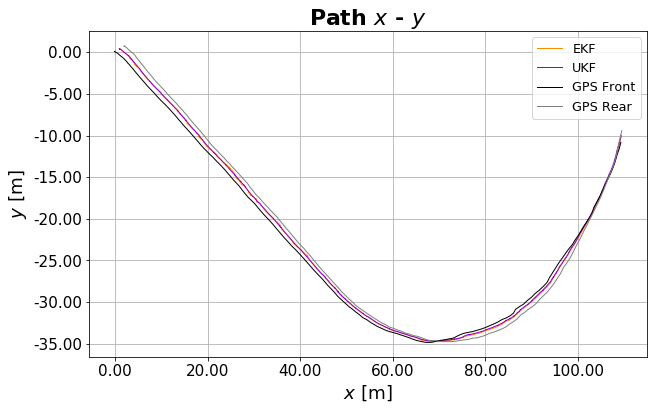

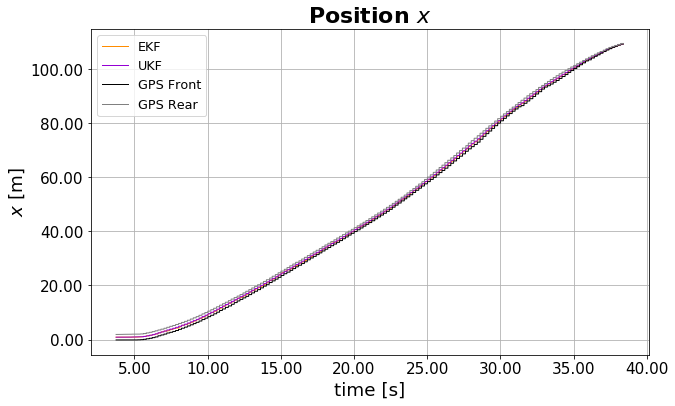

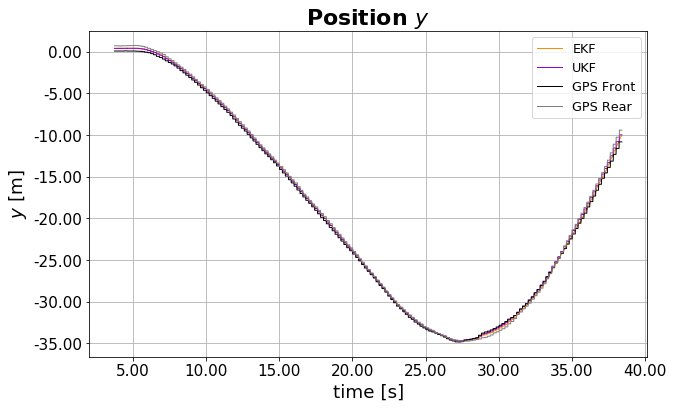

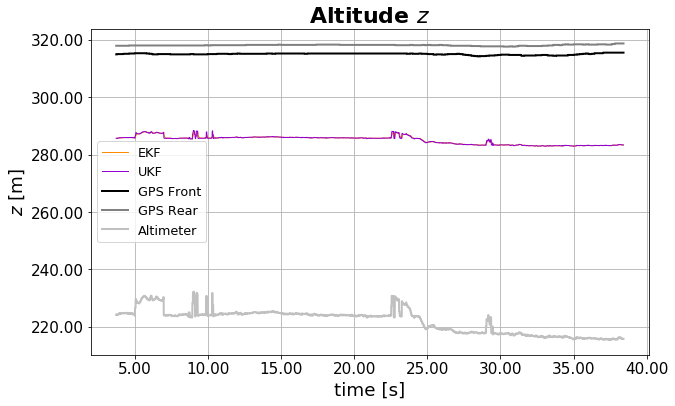

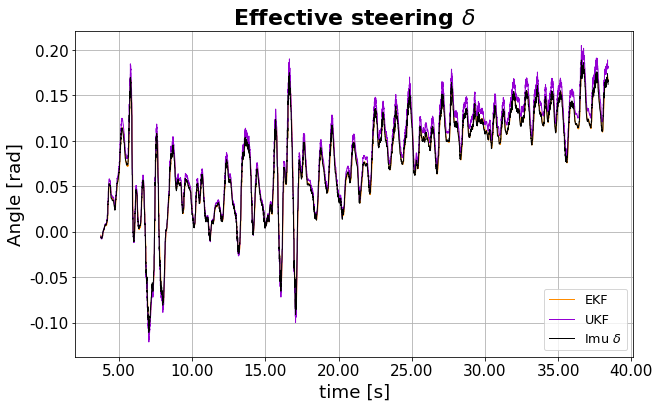

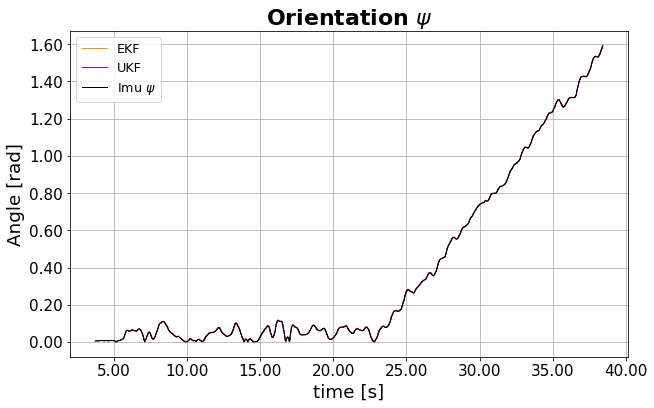

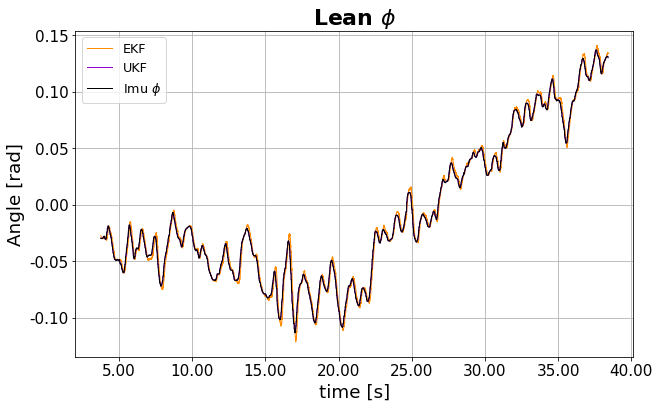

In [7]:
init_pos = 1000
samples =  10000

final_pos = init_pos +  samples

xs_view_ekf_filter = xs_view_ekf[range(init_pos, final_pos), :]
xs_view_ukf_filter = xs_view_ukf[range(init_pos, final_pos), :]
z_view_filter = z_view[range(init_pos, final_pos), :]
time_filter = time[range(init_pos, final_pos),]

path_output_filter = 'filters/EKF_vs_UKF/' + file_name.split("/")[0] + "/"
plot_comparison_real_data(xs_ekf=xs_view_ekf_filter, xs_ukf=xs_view_ukf_filter, 
                          sim=z_view_filter, time=time_filter, 
                          file_name=path_output_filter, dpi=150, format='png')

In [9]:
print("dataset: ", file_name.split("/")[0])

print("Total samples: ", len(diff_t_ukf) )

print("EKF")
print("Mean time EKF: ", np.mean(diff_t_ekf)*1000)
print("Min time EKF: ", np.min(diff_t_ekf)*1000)
print("Max time EKF: ", np.max(diff_t_ekf)*1000)
print("Total time EKF: ", np.sum(diff_t_ekf))
print("UKF")
print("Mean time UKF: ", np.mean(diff_t_ukf)*1000)
print("Min time UKF: ", np.min(diff_t_ukf)*1000)
print("Max time UKF: ", np.max(diff_t_ukf)*1000)
print("Total time UKF: ", np.sum(diff_t_ukf))

dataset:  parking_2
Total samples:  29024
EKF
Mean time EKF:  0.432256917246
Min time EKF:  0.161170959473
Max time EKF:  31.1357975006
Total time EKF:  12.5458247662
UKF
Mean time UKF:  1.46248401887
Min time UKF:  0.86784362793
Max time UKF:  25.7179737091
Total time UKF:  42.4471361637


## Export to Google Earth

In [10]:
import utm
import datetime
from simplekml import Kml, Model, AltitudeMode, Orientation, Scale

# Get real time
time = di.data[[di.time]].as_matrix()

# Get gps_zone_number and  gps_zone_letter
gps_zone = di.data[[di.gps_zone_number, di.gps_zone_letter]].as_matrix()

car={}
car['when']=[]
car['filter_ekf']=[]
car['filter_ukf']=[]
car['gps_front']=[]
car['gps_rear']=[]

for i in range(0, len(time)):
    (lat_filter_ekf, lon_filter_ekf) = utm.to_latlon(xs_ekf[i, 0], xs_ekf[i, 1], gps_zone[i, 0], gps_zone[i, 1])
    (lat_filter_ukf, lon_filter_ukf) = utm.to_latlon(xs_ukf[i, 0], xs_ukf[i, 1], gps_zone[i, 0], gps_zone[i, 1])    
    
    (lat_gps_front, lon_gps_front) = utm.to_latlon(z[i, 0], z[i, 2], gps_zone[i, 0], gps_zone[i, 1])
    (lat_gps_rear, lon_gps_rear) = utm.to_latlon(z[i, 1], z[i, 3], gps_zone[i, 0], gps_zone[i, 1])
    
    d = datetime.datetime.fromtimestamp(float(time[i])/1e9)
    car["when"].append(d.strftime("%Y-%m-%dT%H:%M:%SZ"))
    
    car["filter_ekf"].append((lon_filter_ekf, lat_filter_ekf , 0))
    car["filter_ukf"].append((lon_filter_ukf, lat_filter_ukf , 0))
    
    car["gps_front"].append((lon_gps_front, lat_gps_front, 0))
    car["gps_rear"].append((lon_gps_rear, lat_gps_rear, 0))

# Create the KML document
kml = Kml(name=d.strftime("%Y-%m-%d %H:%M"), open=1)

# Create the track
trk_ekf = kml.newgxtrack(name="EKF", altitudemode=AltitudeMode.clamptoground,
                     description="State Estimation from EKF")

trk_ukf = kml.newgxtrack(name="UKF", altitudemode=AltitudeMode.clamptoground,
                     description="State Estimation from UKF")

gps_front = kml.newgxtrack(name="GPS FRONT", altitudemode=AltitudeMode.clamptoground,
                     description="Raw data from GPS FRONT (input to filter)")

gps_rear = kml.newgxtrack(name="GPS REAR", altitudemode=AltitudeMode.clamptoground,
                     description="Raw data from GPS REAR (input to filter)")

# Add all the information to the track
trk_ekf.newwhen(car["when"])
trk_ekf.newgxcoord(car["filter_ekf"])

trk_ukf.newwhen(car["when"])
trk_ukf.newgxcoord(car["filter_ukf"])

gps_front.newwhen(car["when"][::5])
gps_front.newgxcoord((car["gps_front"][::5]))

gps_rear.newwhen(car["when"][::5])
gps_rear.newgxcoord((car["gps_rear"][::5]))

# Style of the Track
trk_ekf.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/paddle/red-circle.png"
trk_ekf.labelstyle.scale = 1
trk_ekf.linestyle.width = 4
trk_ekf.linestyle.opacity = 1
trk_ekf.linestyle.color = '64F01414' # aabbggrr

trk_ukf.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/paddle/orange-circle.png"
trk_ukf.labelstyle.scale = 1
trk_ukf.linestyle.width = 4
trk_ukf.linestyle.opacity = 1
trk_ukf.linestyle.color = '500078F0'

gps_front.iconstyle.icon.href = ""
gps_front.labelstyle.scale = 0
gps_front.linestyle.width = 4
gps_front.linestyle.opacity = 1
gps_front.linestyle.color = '6414B400'

gps_rear.iconstyle.icon.href = ""
gps_rear.labelstyle.scale = 0
gps_rear.linestyle.width = 4
gps_rear.linestyle.opacity = 1
gps_rear.linestyle.color = '6414F00A'

# Saving
name_output_kmz = path_output_filter + "EKF_vs_UKF_google_earth.kmz"
kml.savekmz(name_output_kmz)

print("Google Earth file saved into: " + name_output_kmz)

Google Earth file saved into: filters/EKF_vs_UKF/parking_2/EKF_vs_UKF_google_earth.kmz
